# Case study: re-analysis of hydra (*Hydra vulgaris*) single-cell data

This notebook will demonstrate scRNA-seq processing with orthomap using hydra scRNA data from ([Cazet et al., 2022](https://doi.org/10.1101/2022.06.21.496857)).

scRNA data were obtained from https://research.nhgri.nih.gov/HydraAEP, converted into Scanpy `AnnData` objects ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)) and are availabe here:

https://doi.org/10.5281/zenodo.7366178

or can be accessed with the `dataset` submodule of `oggmap`

`datasets.cazet22(datapath='data')` (download folder set to `'data'`).

## Notebook file

Notebook file can be obtained here:

[https://raw.githubusercontent.com/kullrich/oggmap/main/docs/notebooks/hvulgaris_example.ipynb](https://raw.githubusercontent.com/kullrich/oggmap/main/docs/notebooks/hvulgaris_example.ipynb)

## Steps

To process the scRNA data, we will do the following:

0. Use pre-calculated gene age classification
1. Get query species taxonomic lineage information
2. Get query species orthomap
3. Map OrthoFinder gene names and scRNA gene/transcript names
4. Get TEI values and add them to scRNA dataset
5. Get partial TEI values to visualize gene age class contributions
6. Process scRNA data and visualize TEI

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
# increase dpi
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['figure.figsize'] = [4.4, 3.3]

## Import oggmap python package submodules

In [2]:
# import submodules
from oggmap import qlin, gtf2t2g, of2orthomap, orthomap2tei, datasets

## Step 0 - Use pre-calculated gene age classification

Orthomap was pre-calculated ([Cazet et al., 2022](https://doi.org/10.1101/2022.06.21.496857)) and obtained from here https://research.nhgri.nih.gov/HydraAEP, it is also available here:

https://doi.org/10.5281/zenodo.7242263

or can be accessed with the `dataset` submodule of `oggmap`

`datasets.cazet22_orthomap('data')` (download folder set to `'data'`).

If you want to use your own OrthoFinder results:

`oggmap` can extract gene age classification from existing OrthoFinder results and link them with scRNA data.

A detailed how-to is available here:

https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html

In [3]:
# download pre-calculated orthomap into data folder
datasets.cazet22_orthomap('data')

100% [........................................................] 264477 / 264477

'data/Cazet2022_Orthomap.tsv'

## Step 1 - get query species taxonomic lineage information

Given a species name or taxonomic ID, the query species lineage information is extracted with the help of the `ete3` python toolkit and the `NCBI taxonomy` ([Huerta-Cepas et al., 2016](https://doi.org/10.1093/molbev/msw046)). This information is needed alongside with the taxonomic classifications for all species used in the OrthoFinder comparison.

The `oggmap` submodule `qlin` helps to get this information for you with the `qlin.get_qlin()` function as follows:

In [4]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Hydra vulgaris')

query name: Hydra vulgaris
query taxID: 6087
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Cnidaria(6073)', 'Hydrozoa(6074)', 'Hydroidolina(37516)', 'Anthoathecata(406427)', 'Aplanulata(1612408)', 'Hydridae(6080)', 'Hydra(6083)', 'Hydra vulgaris(6087)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 6073, 6074, 37516, 406427, 1612408, 6080, 6083, 6087]


## Step 2 - gene age class assignment (query species orthomap)

Orthomap was pre-calculated ([Cazet et al., 2022](https://doi.org/10.1101/2022.06.21.496857)) and obtained from here https://research.nhgri.nih.gov/HydraAEP, it is also available here:


https://github.com/cejuliano/brown_hydra_genomes/blob/main/06_geneAge/geneAge.csv

and here:

https://doi.org/10.5281/zenodo.7242263

or can be accessed with the `dataset` submodule of `oggmap`

`datasets.cazet22_orthomap('data')` (download folder set to `'data'`).

The pre-calculated orthomap can be imported with the `read_orthomap` function from the `orthomap2tei` submodule as follwos:

In [5]:
# get query species orthomap

# download pre-calculated orthomap here: https://doi.org/10.5281/zenodo.7242263
# or download with datasets.cazet22_orthomap('data')
query_orthomap = orthomap2tei.read_orthomap(orthomapfile='data/Cazet2022_Orthomap.tsv')
query_orthomap

,age,ID,ageN
0,N36,G013495,11
1,N36,G012562,11
2,N36,G013704,11
3,N36,G012561,11
4,N36,G013496,11
...,...,...,...
19944,N0,G000765,1
19945,N0,G000767,1
19946,N0,G001616,1
19947,N0,G015670,1


### Gene age assignments per query species lineage node

Given an orthomap, one can get an overview of the gene age assignments per query species lineage node.

The `oggmap` submodule `of2orhomap` and the `of2orthomap.get_counts_per_ps()` function will show the distribution of the gene age classes and can be further visualized as follows:

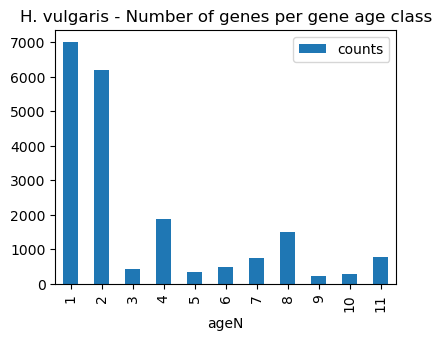

In [6]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(omap_df=query_orthomap,
    psnum_col='ageN',
    pstaxid_col=None,
    psname_col=None)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(omap_df=query_orthomap,
    psnum_col='ageN',
    pstaxid_col=None,
    psname_col=None).plot.bar(y='counts', x='ageN')
ax.set_title('H. vulgaris - Number of genes per gene age class')
plt.show()

## Step 3 - map OrthoFinder gene names and scRNA gene/transcript names

To be able to link gene ages assignments from an orthomap and gene or transcript of scRNA dataset, one needs to check the overlap of the annotated gene names. With the `gtf2t2g` submodule of `orthomap` and the `parse_gtf` function, one can extract gene and transcript names from a given gene feature file (`GTF`).

Here, pre-calculated orthomap gene names already overlap, so no `GTF` import is necessary ([Cazet et al., 2022](https://doi.org/10.1101/2022.06.21.496857)).

If in your case gene or transcript IDs between an orthomap and scRNA data do not match directly, please have a look at a detailed how-to to match them:

https://oggmap.readthedocs.io/en/latest/tutorials/geneset_overlap.html

### Import now, the scRNA dataset of the query species

Here, data is used like in the original publication ([Cazet et al., 2022](https://doi.org/10.1101/2022.06.21.496857)).

scRNA data were downloaded from https://research.nhgri.nih.gov/HydraAEP, converted into Scanpy `AnnData` objects ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)) and are availabe here:

https://doi.org/10.5281/zenodo.7366178

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.cazet22('data')` (download folder set to `'data'`).

In [7]:
# load scRNA data

# download hydra scRNA data here: https://doi.org/10.5281/zenodo.7366178
# or download with datasets.cazet22(datapath='data')

#hvulgaris_data = datasets.cazet22('data')
hvulgaris_data = sc.read(filename='data/aepAtlasNonDub.h5ad')

### Get an overview of observations

In [8]:
hvulgaris_data

AnnData object with n_obs × n_vars = 29339 × 20159
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.7', 'seurat_clusters', 'curatedIdent', 'mg1', 'mg2', 'mg3', 'mg4', 'mg5', 'mg6', 'mg7', 'mg8', 'mg9', 'mg10', 'mg11', 'mg12', 'mg13', 'mg14', 'mg15', 'mg16', 'mg17', 'mg18', 'mg19', 'mg20', 'mg21', 'mg22', 'mg23', 'mg24', 'mg25', 'mg26', 'mg27', 'mg28', 'mg29', 'mg30', 'mg31', 'mg32', 'mg33', 'mg34', 'mg35', 'mg36', 'mg37', 'mg38', 'mg39', 'mg40', 'mg41', 'mg42', 'mg43', 'mg44', 'mg45', 'mg46', 'mg47', 'mg48', 'mg49', 'mg50', 'mg51', 'mg52', 'mg53', 'mg54', 'mg55', 'mg56', 'RUNX1;MA0002.2', 'TFAP2A;MA0003.4', 'Arnt;MA0004.1', 'Ahr::Arnt;MA0006.1', 'TBXT;MA0009.2', 'br(var.2);MA0011.1', 'br(var.4);MA0013.1', 'PAX5;MA0014.3', 'NR2F1;MA0017.2', 'CREB1;MA0018.4', 'dl;MA0022.1', 'E2F1;MA0024.3', 'NFIL3;MA0025.2', 'Eip74EF;MA0026.1', 'ELK1;MA0028.2', 'FOXF2;MA0030.1', 'FOXD1;MA0031.1', 'FOXC1;MA0032.2', 'GATA2;MA0036.3', 'GFI1;MA0038.2', 

In [9]:
hvulgaris_data.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,integrated_snn_res.0.7,seurat_clusters,curatedIdent,mg1,mg2,...,ZNF449;MA1656.1,ZNF652;MA1657.1,FOXA3;MA1683.1,ceh-38;MA1699.1,Clamp;MA1700.1,elt-2;MA1701.1,Pdp1;MA1702.1,pqm-1;MA1703.1,zip-8;MA1704.1,TAI
TTTCCGTAGAAN-D01-D1_S1,D01-D1_S1,64276.0,6699,8505.0,3008,11,11,Ec_Head,0.000000,0.000000,...,0.005337,0.000000,0.058842,0.021006,0.238216,0.136273,0.000000,0.000000,0.914948,3.797976
CAGTACCCGCTT-D01-D1_S1,D01-D1_S1,63988.0,6380,7836.0,2400,9,9,En_Foot,0.070943,0.000000,...,0.000000,0.000000,0.465768,0.000000,0.003879,0.050755,0.000000,0.001250,0.235164,3.969117
CTTTTCCGATGA-D01-D1_S1,D01-D1_S1,69511.0,6770,8178.0,2645,0,0,En_BodyCol/SC,0.000000,0.013072,...,0.000000,0.000000,1.003803,0.097580,0.000000,0.000000,0.000000,0.000000,0.434233,3.526038
GCTCCCGCCCGC-D01-D1_S1,D01-D1_S1,69530.0,6241,7915.0,2251,6,6,En_Head,0.022236,0.007755,...,0.001358,0.000000,1.322596,0.676596,0.000000,0.005780,0.000000,0.000000,0.646697,3.636835
TTTATGATTAGG-D01-D1_S1,D01-D1_S1,65456.0,6867,7889.0,2920,0,0,En_BodyCol/SC,0.000000,0.000000,...,0.001410,0.006779,0.509137,0.000000,0.073598,0.001549,0.008877,0.022202,0.272550,3.520175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGTCGCCGTGC-D12-N2_S2,D12-N2_S2,501.0,351,804.0,379,24,24,I_En1N,0.033858,0.000000,...,0.099983,0.000000,0.051087,0.000000,0.058318,0.000000,0.013654,1.106784,0.072763,4.124720
GGCGTCTGTGCG-D12-N2_S2,D12-N2_S2,510.0,309,823.0,334,12,12,I_DesmoNB,0.000000,0.000000,...,0.000000,0.986436,0.023317,0.024707,0.000000,0.000000,0.000000,0.000000,0.022734,4.331113
AGGGTTCGCTCA-D12-N2_S2,D12-N2_S2,524.0,356,816.0,380,23,23,I_Ec1N,0.000000,0.015268,...,0.000425,0.000000,0.007155,0.000000,0.000000,0.000000,0.000000,0.000000,1.107668,4.511764
GGTGGGTTATAC-D12-N2_S2,D12-N2_S2,652.0,383,862.0,386,24,24,I_En1N,0.085185,0.004089,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.025188,0.000000,1.879879,0.023827,4.127208


### Helper functions to match gene names

The `orthomap2tei` submodule contains the `orthomap2tei.geneset_overlap()` helper function to check for gene name overlap between the constructed orthomap from `OrthoFinder` results and a given scRNA dataset.

In [10]:
# check overlap of orthomap <seqID> and scRNA data <var_names>
orthomap2tei.geneset_overlap(geneset1=hvulgaris_data.var_names,
                             geneset2=query_orthomap['ID'])

,g1_g2_overlap,g1_ratio,g2_ratio
0,19949,0.989583,1.0


## Step 4 - Get TEI values and add them to scRNA dataset

Since now the gene names correspond to each other in the orthomap and the scRNA `adata` object, one can calculate the transcriptome evolutionary index (`TEI`) and add them to the scRNA dataset (`adata` object).

The `TEI` measure represents the weighted arithmetic mean (expression levels as weights for the phylostratum value) over all evolutionary age categories denoted as _phylostra_.

${TEI_s = \sum (e_{is} * ps_i) / \sum e_{is}}$

, where ${TEI_s}$ denotes the `TEI` value in developmental stage ${s, e_{is}}$ denotes the gene expression level of gene ${i}$ in stage ${s}$, and ${ps_i}$ denotes the corresponding phylostratum of gene ${i, i = 1,...,N}$ and ${N = total\ number\ of\ genes}$.

Note: If e.g. two different isoforms would fall into two different gene age classes, their gene ages might differ based on the oldest ortholog found in their corresponding orthologous groups. However, both isoforms share the same gene name and their gene ages would clash. In this case one can decide either to use the `keep='min'` or `keep='max'` gene age to be kept by the `get_tei` function, which defaults to keep in this cases the `keep='min'` or in other words the 'older' gene age.

To be able to re-use the original `count` data, they are added as a new `layer` to the `adata` object. This is useful because later on the `count` data can be used to extract either the relative expression per gene age class or re-calculate other metrics. 

This can be done either on un-normalized `counts`, on `normalized` and `log-transformed` data.

In [11]:
hvulgaris_data.layers['counts'] = hvulgaris_data.X

### add TEI to adata object

Using the submodule `orthomap2tei` from `orthomap` and the `orthomap2tei.get_tei()` function, transcriptome evolutionary index (`TEI`) values are calculated and directyl added to the existing `adata` object (`add_obs=True`).

There are other options to e.g. not start from the `adata.X` `counts` but from another `layer` from the `adata` object, the default is to use the `adata.X` (`layer=None`). The values can be pre-processed by the `normalize_total` option and the `log1p` option.

If `add_obs=True` the resulting `TEI` values are added to the existing `adata` object as a new observation with the name set with the `obs_name` option.

If `add_var=True` the gene age values are added to the existing `adata` object as a new variable with the name set with the `var_name` option.

__Note:__ Genes not assigned to any gene class will get a missing assignment.

If one wants to calculate bootstrap `TEI` values per cell, the `boot` option can be set to `boot=True` and gene age classes will be randomly chosen prior calculating `TEI` values `bt=10` times.

In [12]:
# add TEI values to existing adata object
orthomap2tei.get_tei(adata=hvulgaris_data,
    gene_id=query_orthomap['ID'],
    gene_age=query_orthomap['ageN'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='Phylostrata',
    add_obs=True,
    obs_name='tei',
    boot=False,
    bt=10,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)

,tei
TTTCCGTAGAAN-D01-D1_S1,1.885530
CAGTACCCGCTT-D01-D1_S1,2.552758
CTTTTCCGATGA-D01-D1_S1,2.821474
GCTCCCGCCCGC-D01-D1_S1,2.825493
TTTATGATTAGG-D01-D1_S1,2.162769
...,...
GGGTCGCCGTGC-D12-N2_S2,2.435130
GGCGTCTGTGCG-D12-N2_S2,2.513725
AGGGTTCGCTCA-D12-N2_S2,2.879771
GGTGGGTTATAC-D12-N2_S2,2.387097


## Step 5 - downstream analysis

Once the gene age data has been added to the scRNA dataset, one can e.g. plot the corresponding transcriptome evolutionary index (`TEI`) values by any given observation pre-defined in the scRNA dataset.

Here, we plot them against the assigned embryo stage and against assigned cell types of the zebrafish using the `scanpy` `sc.pl.violin()` function as follows:

### Boxplot gene age class per sample timepoint

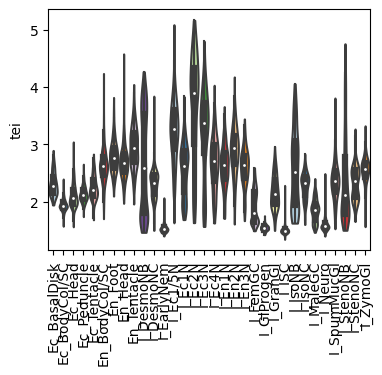

In [13]:
sc.pl.violin(adata=hvulgaris_data,
             keys=['tei'],
             groupby='curatedIdent',
             rotation=90,
             palette='Paired',
             stripplot=False,
             inner='box')

### Get partial TEI values to visualize gene age class contributions

Partial `TEI` values can give an idea about which gene age class contributed at most to the `global` `TEI` pattern.

In detail, each gene gets a `TEI` contribution profile as follows:

${TEI_{is} = f_{is} * ps_i}$

, where ${TEI_{is}}$ is the partial `TEI` value of gene ${i}$, ${f_{is} = e_{is} / \sum e_{is}}$ and ${ps_i}$ is the phylostratum of gene i.

${TEI_{is}}$ values are combined per ${ps}$.

The partial `TEI` values combined per strata give an overall impression of the contribution of each strata to the `global` `TEI` pattern.

One can either start from `counts` (`adata.X`) which is set as default or any other `layer` defined by the `layer` option (`layer=None`).

In addition, the `counts` can be `normalized` and `log-transformed` prior calculating partial `TEI` values (`normalize_total=False`, `log1p=False`, `target_sum=1e6`).

Further, these values can be combined per given observation, e.g. cell type (`group_by='cell.type'`).

The `get_pstrata` function of the `orthomap2tei` submodule will return two matrix, the first contains the sum of each partial `TEI` per gene age class and the second the corresponding frequencies.

Both can be further processed by returning the `cumsum` over the gene age classes. To get them set the option `cumsum=True`. The `cumsum` will result in either for the first matrix the `TEI` value per cell or mean `TEI` value per group, if one choose a observation with the `group_by` option. Or in case of the second frequency matrix will result in 1.

With the `standard_scale` option either gene age classes (`standard_scale=0` rows) or cells or groups (`standard_scale=1` columns) can be scaled, subtract the minimum and divide each by its maximum. By default no scaling is applied (`standard_scale=None`).

Here, we will scale each gene age class (`standard_scale=0`) to reproduce findings from original publication ([Cazet et al., 2022](https://doi.org/10.1101/2022.06.21.496857)).

The resulting data will be visualized in the downstream section.

In [14]:
hvulgaris_pstrata = orthomap2tei.get_pstrata(adata=hvulgaris_data,
    gene_id=query_orthomap['ID'],
    gene_age=query_orthomap['ageN'],
    keep='min',
    layer=None,
    cumsum=False,
    group_by_obs='curatedIdent',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=None,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)
hvulgaris_pstrata[0]

curatedIdent,Ec_BasalDisk,Ec_BodyCol/SC,Ec_Head,Ec_Peduncle,Ec_Tentacle,En_BodyCol/SC,En_Foot,En_Head,En_Tentacle,I_DesmoNB,...,I_GranGl,I_ISC,I_IsoNB,I_IsoNC,I_MaleGC,I_Neuro,I_SpumMucGl,I_StenoNB,I_StenoNC,I_ZymoGl
ps,,,,,,,,,,,,,,,,,,,,,
1,0.560994,0.595713,0.590387,0.581276,0.562467,0.589827,0.580900,0.581904,0.562355,0.589530,...,0.598142,0.670901,0.574888,0.554668,0.635307,0.661613,0.605504,0.612284,0.553138,0.592371
2,0.511210,0.496005,0.495925,0.498049,0.499676,0.508730,0.507193,0.513416,0.521005,0.444571,...,0.502875,0.469989,0.453770,0.505122,0.497674,0.467740,0.484118,0.436852,0.505544,0.496516
3,0.036718,0.033811,0.034563,0.037433,0.038390,0.040587,0.043163,0.040554,0.036169,0.028546,...,0.036281,0.027780,0.028548,0.044000,0.035234,0.028230,0.036847,0.027264,0.044341,0.034395
4,0.195327,0.172565,0.173816,0.187209,0.207873,0.169317,0.175720,0.175979,0.186915,0.151476,...,0.191275,0.105603,0.173582,0.177877,0.110640,0.114570,0.174782,0.149452,0.188667,0.219986
5,0.076601,0.064414,0.065810,0.067613,0.073942,0.068400,0.071836,0.071641,0.082624,0.183921,...,0.065494,0.044966,0.181550,0.107528,0.053688,0.046995,0.065424,0.154116,0.119037,0.060822
6,0.137453,0.108081,0.109838,0.116427,0.129939,0.089112,0.097962,0.095880,0.108046,0.205680,...,0.096518,0.066193,0.232879,0.136739,0.080290,0.069968,0.098696,0.173043,0.133907,0.123893
7,0.175829,0.164752,0.167630,0.174248,0.198587,0.126557,0.128408,0.136689,0.153862,0.231249,...,0.155013,0.112669,0.181249,0.236929,0.142587,0.120460,0.127831,0.154073,0.215567,0.153125
8,0.311870,0.248873,0.260274,0.267582,0.317446,0.287415,0.318531,0.302624,0.348600,0.228224,...,0.223682,0.128542,0.264267,0.338612,0.174242,0.161667,0.280838,0.255724,0.331506,0.216531
9,0.033367,0.031295,0.032025,0.035780,0.039247,0.045665,0.049970,0.042696,0.049330,0.019145,...,0.023680,0.012810,0.025420,0.022936,0.026645,0.013645,0.019248,0.015464,0.023421,0.025568


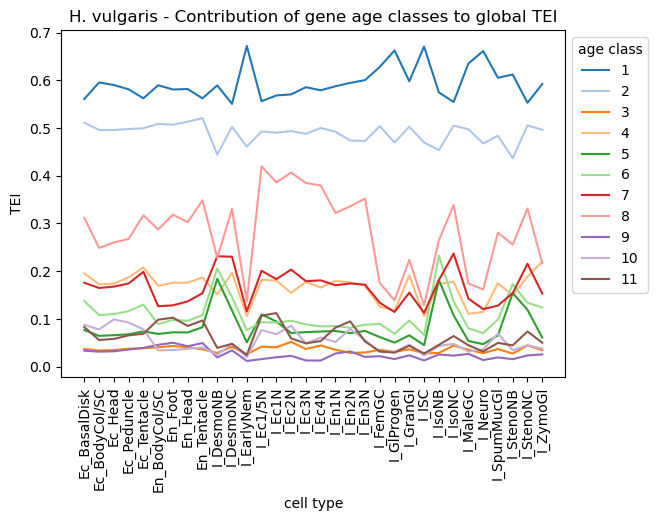

In [16]:
plt.rcParams['figure.figsize'] = [6.5, 4.5]
ax = sns.lineplot(hvulgaris_pstrata[0].transpose(), palette='tab20', dashes=False)
ax.legend(fontsize=3, title='age class')
ax.set_title('H. vulgaris - Contribution of gene age classes to global TEI')
ax.set_xlabel('cell type')
ax.set_ylabel('TEI')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()
plt.rcParams['figure.figsize'] = [4.4, 3.3]

### Heatmap partial TEI per gene age class

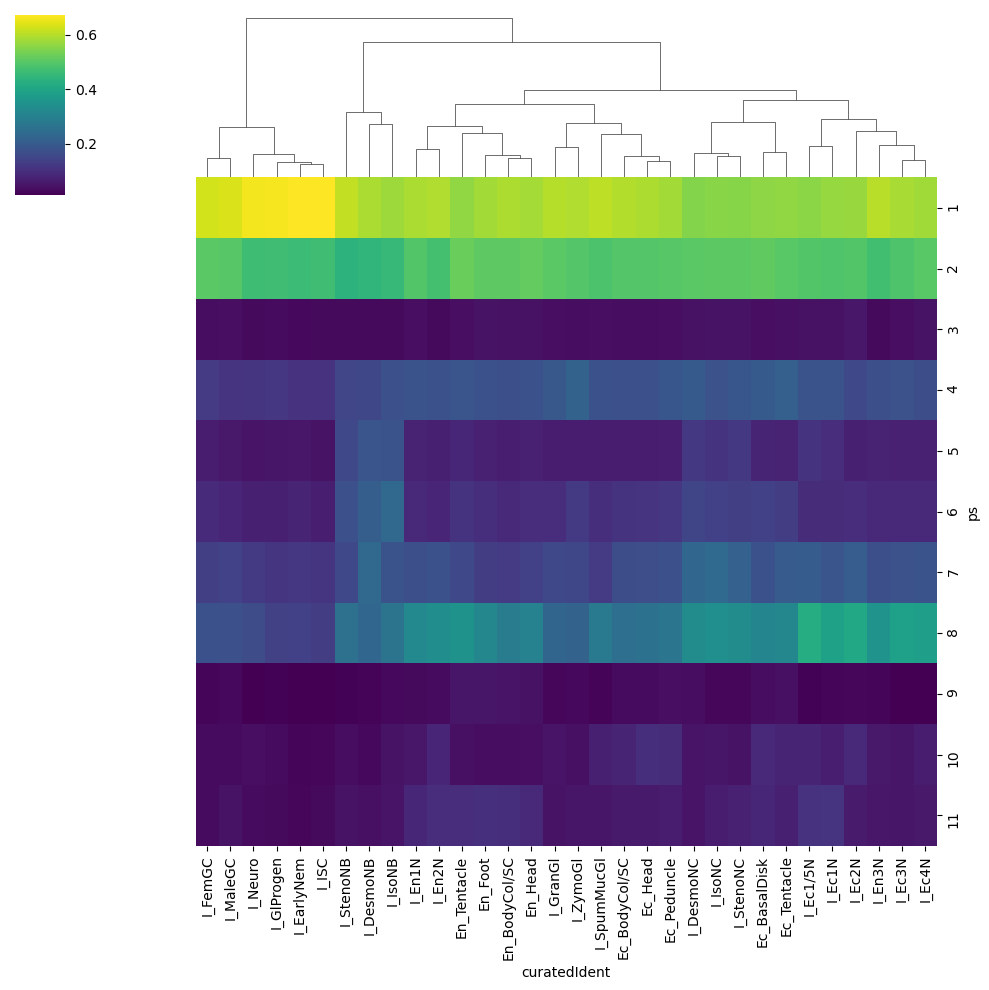

In [17]:
sns.clustermap(data=hvulgaris_pstrata[0],
               row_cluster=False,
               col_cluster=True,
               cmap='viridis')

### Heatmap partial TEI cumsum per gene age class and sample timepoint - first matrix

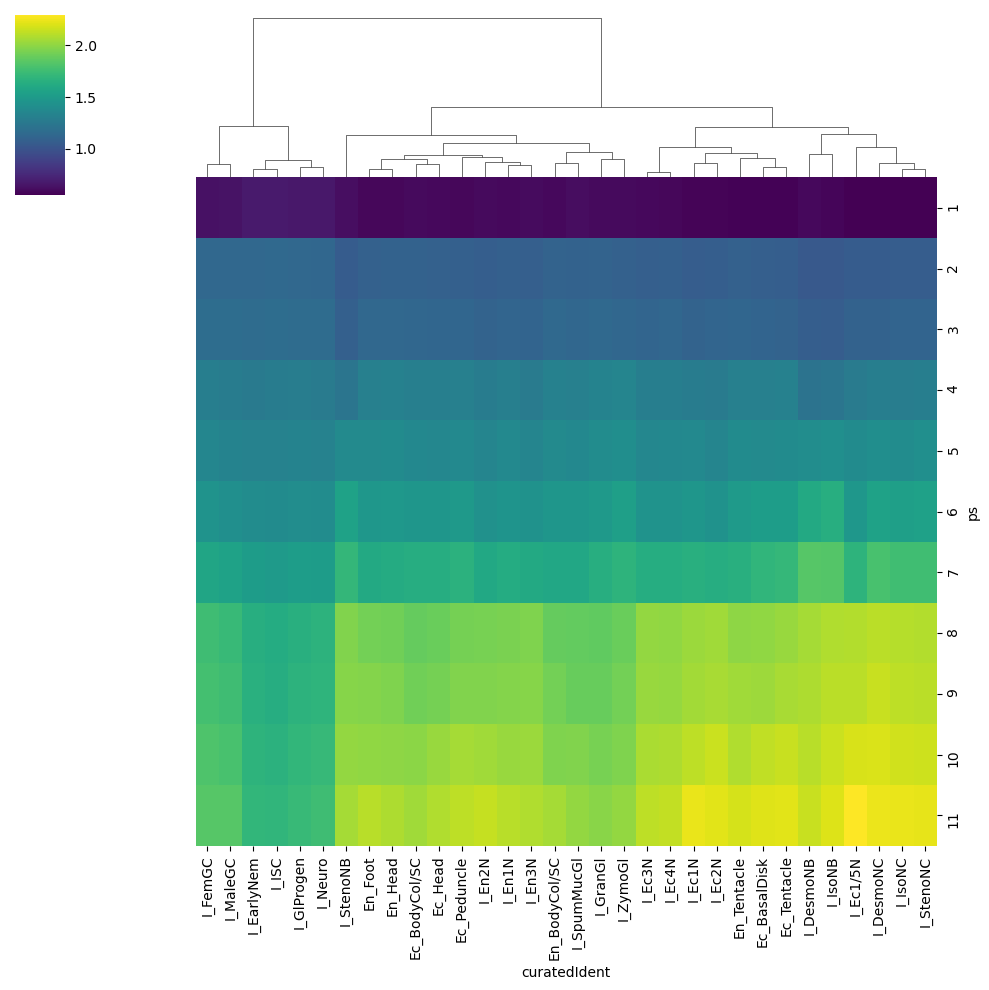

In [18]:
sns.clustermap(data=hvulgaris_pstrata[0].cumsum(0),
               row_cluster=False,
               col_cluster=True,
               cmap='viridis')

### Heatmap partial TEI per gene age class and sample timepoint - second matrix (frequencies)

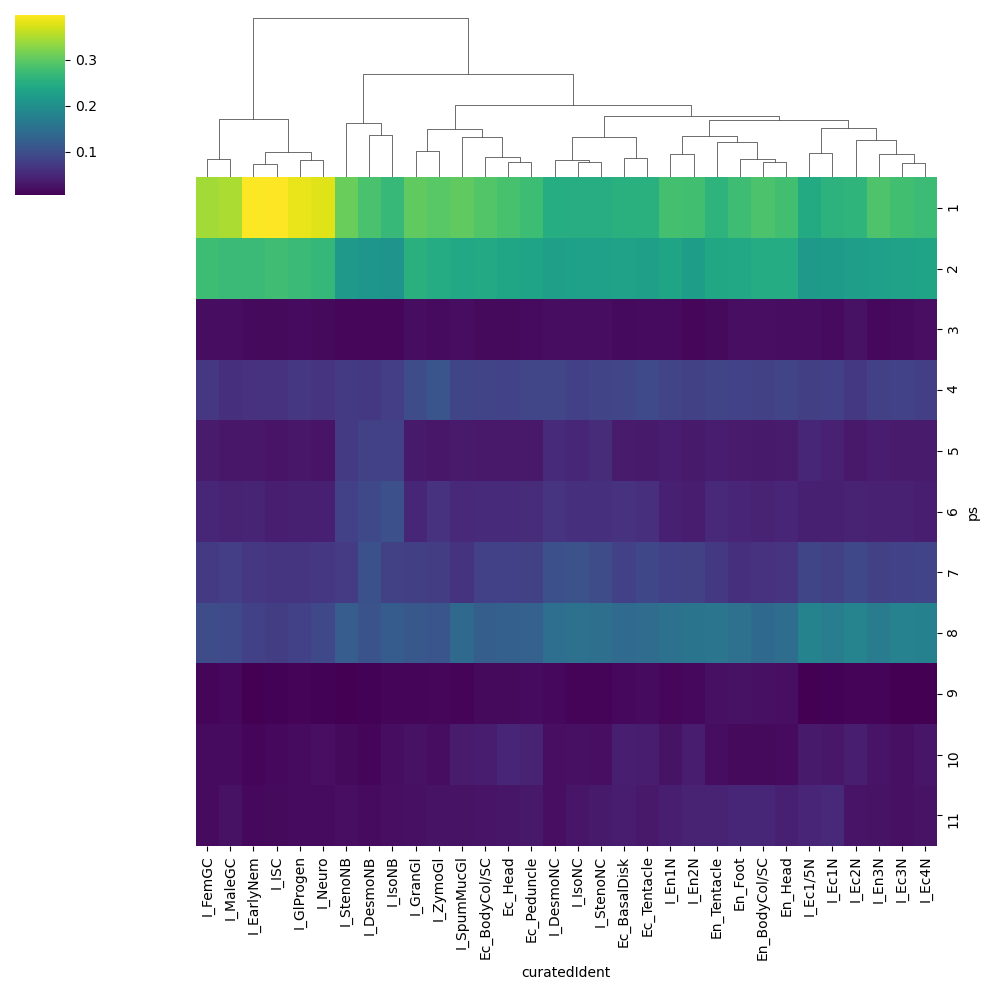

In [19]:
sns.clustermap(data=hvulgaris_pstrata[1],
               row_cluster=False,
               col_cluster=True,
               cmap='viridis')

### Heatmap partial TEI cumsum per gene age class and sample timepoint - second matrix (frequencies)

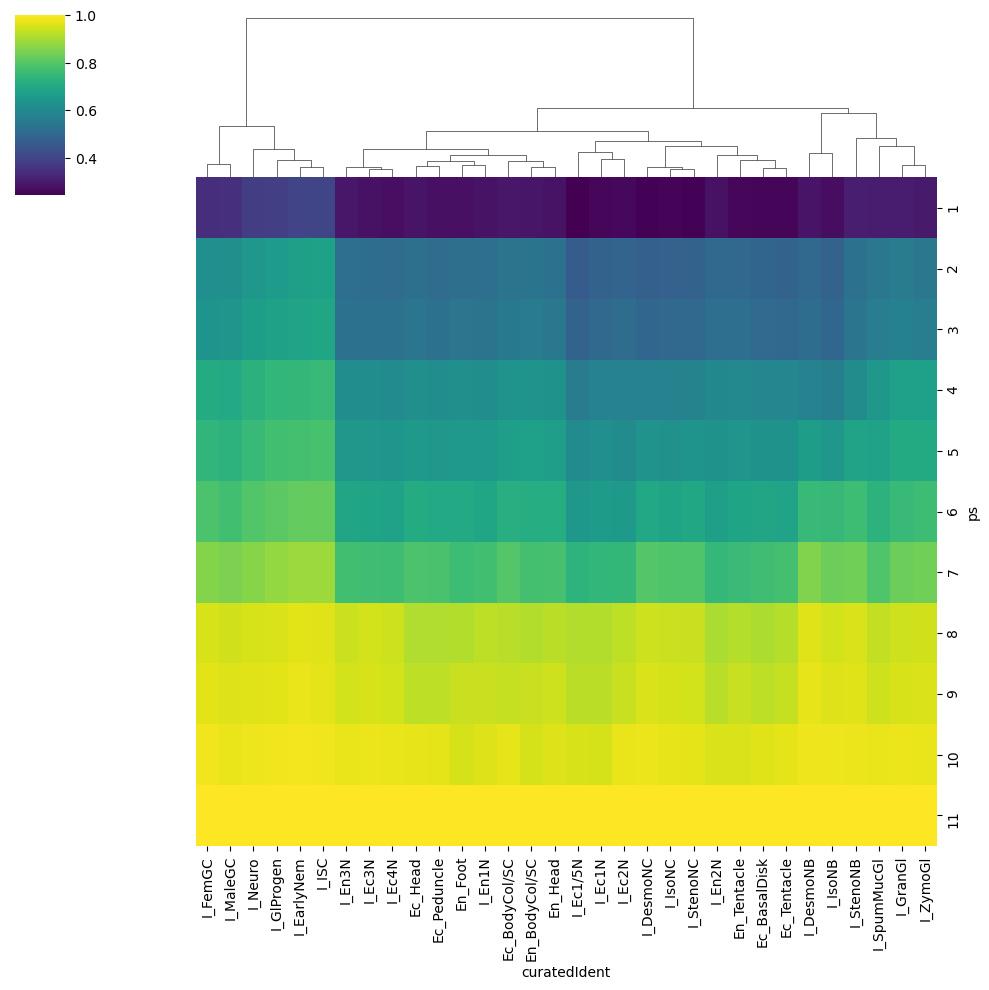

In [20]:
sns.clustermap(data=hvulgaris_pstrata[1].cumsum(0),
               row_cluster=False,
               col_cluster=True,
               cmap='viridis')

### Color UMAP/TSNE by TEI

Follwoing the basic tutorial of the Scanpy python toolkit ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)), one can highlight `TEI` values on a dimensional reduction of the scRNA dataset, like `PCA`, `UMAP` or `TSNE`.

#### Filtering

In [21]:
sc.pp.filter_genes(hvulgaris_data, min_cells=3)
sc.pp.filter_cells(hvulgaris_data, min_genes=200)

#### Normalization, Log transformation and Scaling

In [22]:
sc.pp.normalize_total(hvulgaris_data, target_sum=1e6)
sc.pp.log1p(hvulgaris_data)
sc.pp.scale(hvulgaris_data, max_value=10)

#### PCA and Neighbor calculations

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


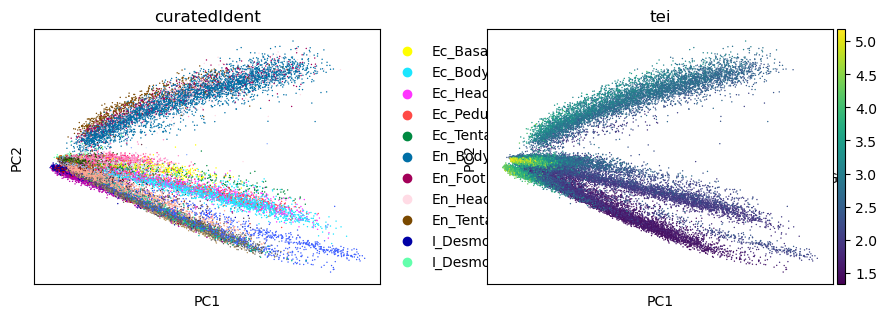

In [23]:
sc.tl.pca(hvulgaris_data, svd_solver='arpack')
sc.pl.pca(hvulgaris_data, color=['curatedIdent', 'tei'])

In [24]:
sc.pp.neighbors(hvulgaris_data)

#### Embedding the neighborhood graph

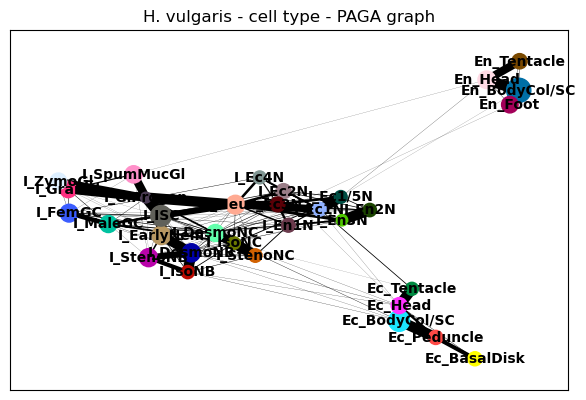

In [25]:
plt.rcParams['figure.figsize'] = [6.5, 4.5]
sc.tl.paga(hvulgaris_data, groups='curatedIdent')
sc.pl.paga(hvulgaris_data, title='H. vulgaris - cell type - PAGA graph')
plt.rcParams['figure.figsize'] = [4.4, 3.3]

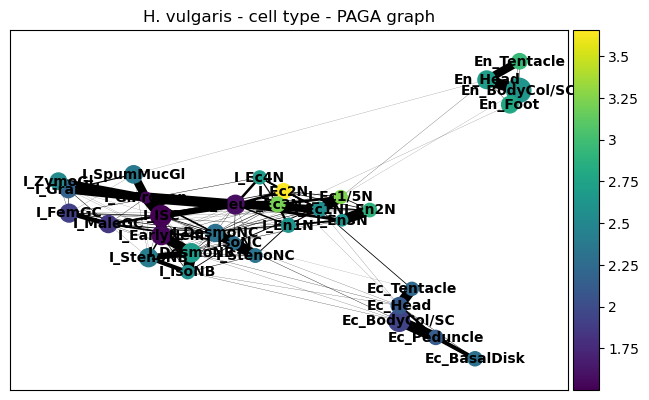

In [26]:
plt.rcParams['figure.figsize'] = [6.5, 4.5]
sc.pl.paga(hvulgaris_data, title='H. vulgaris - cell type - PAGA graph', color=['tei'])
plt.rcParams['figure.figsize'] = [4.4, 3.3]

#### UMAP

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


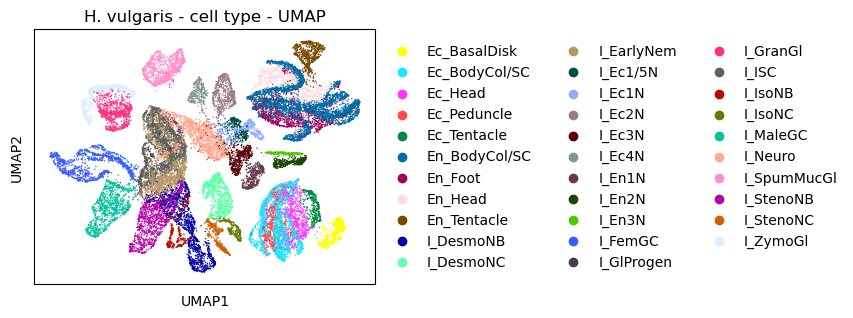

In [27]:
sc.tl.umap(hvulgaris_data,
           init_pos='paga')
sc.pl.umap(hvulgaris_data,
           title='H. vulgaris - cell type - UMAP', color=['curatedIdent'])

#### Color UMAP by TEI

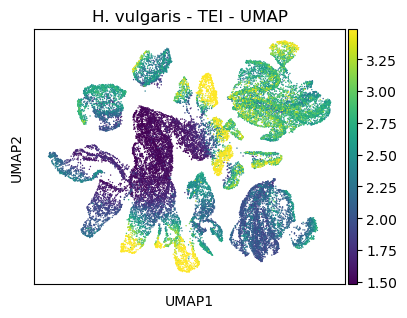

In [28]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(hvulgaris_data,
           title='H. vulgaris - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]

#### 3D-UMAP

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


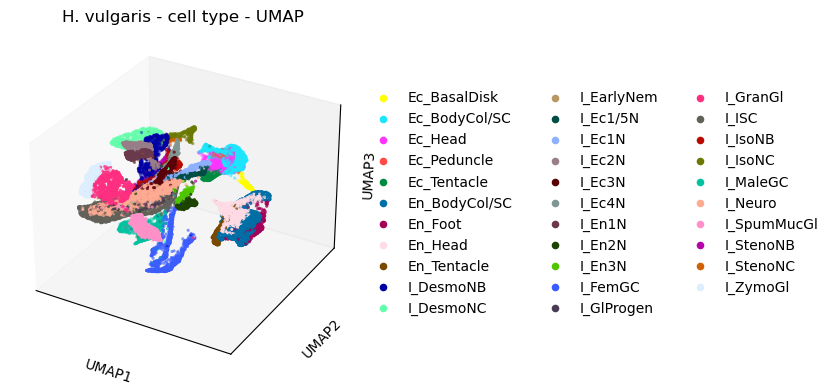

In [29]:
plt.rcParams['figure.figsize'] = [7.5, 4.5]
#3d
sc.tl.umap(hvulgaris_data,
           n_components=3)
sc.pl.umap(hvulgaris_data,
           title='H. vulgaris - cell type - UMAP',
           color=['curatedIdent'],
           projection='3d')
plt.rcParams['figure.figsize'] = [4.4, 3.3]

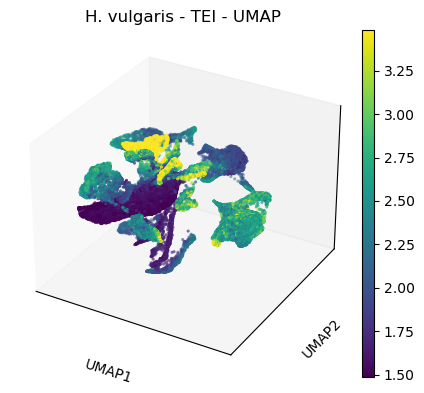

In [30]:
plt.rcParams['figure.figsize'] = [7.5, 4.5]
#3d
sc.pl.umap(hvulgaris_data,
           title='H. vulgaris - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95',
           projection='3d')
plt.rcParams['figure.figsize'] = [4.4, 3.3]

Please have a look at the documentation for other [case studies](https://oggmap.readthedocs.io/en/latest/tutorials/index.html#case-studies).